# More Burlington Housing 

In this notebook I am going to use a class created here: to fit machine learning models to the Burlington Housing Price data. I've done this in the past, but I want to try some new ideas and see how well they work to predict Burlington Housing Prices. I'll start by importing data from various sources:

* Burington Housing data from the Burlington Socrata Portal

* Vermont Housing Price Index data from Quandl

* Vermont GDP data from Quandl

I join these datasets by year, to create a one dataset to try to predict the sale price of properties in Burlington.

In [1]:
#for tablular data managment 
import pandas as pd 
#for scientific plotting 
import seaborn as sns 
import matplotlib.pyplot as plt
import quandl
#pythons premiere numerical computing library 
import numpy as np
from sklearn.model_selection import GridSearchCV
plt.style.use('ggplot')
%matplotlib inline
#Read in csv from Burlington Open data
df = pd.read_csv("https://opendata.arcgis.com/datasets/276ccff527454496ac940b60a2641dda_0.csv")
#Split the 'PropertyCenterPoint' column into 'Latitude' and 'Longitude' in a seperate dataframe
df2 = df['PropertyCenterPoint'].str.strip('()').str.split(', ', expand=True).rename(columns={0:'Latitude', 1:'Longitude'})
df3 = df['Baths'].str.split('/', expand=True).rename(columns={0:'Full_Baths', 1:'Half_Baths'})
# create a dataframe with the new variables
df = pd.concat([df, df2, df3],axis=1)
df.drop('PropertyCenterPoint', 1, inplace = True)
df['Half_Baths'] = pd.to_numeric(df['Half_Baths'])
df['Full_Baths'] = pd.to_numeric(df['Full_Baths'])
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
df['Year'] = df['SaleDate'].apply(lambda row: row.year)
df = df[df['Year'] > 1996]
df['Year'] = df['Year'].astype(int)

In [2]:
mydata = quandl.get("FRED/VTNGSP", start_date="1931-01-01")
mydata2 = quandl.get("FRED/VTSTHPI", start_date="1931-01-01")
mydata = mydata.reset_index()
mydata2 = mydata2.resample('A').mean()
mydata2 = mydata2.reset_index()
mydata['Year'] = mydata['Date'].apply(lambda row: row.year)
mydata2['Year'] = mydata2['Date'].apply(lambda row: row.year)
mydata = mydata.rename(columns = {'Value': 'VermontGDP'})
mydata2 = mydata2.rename(columns = {'Value': 'VermontHPI'})
mydata = mydata.drop('Date', 1)
mydata2 = mydata2.drop('Date', 1)
df = df.merge(mydata, 'left', on = 'Year')
df = df.merge(mydata2, 'left', on = 'Year')
print("Dataframe dimensions:", df.shape)

Dataframe dimensions: (4605, 45)


By using the .hist() method I can plot all the numeric columns as histograms.  Something that stands out right off is that many of these distributions are not symetric.  Typically within the field of statistical modeling, we prefer to have symetric distributions of predictiors because this is an assumption of many algorithms.

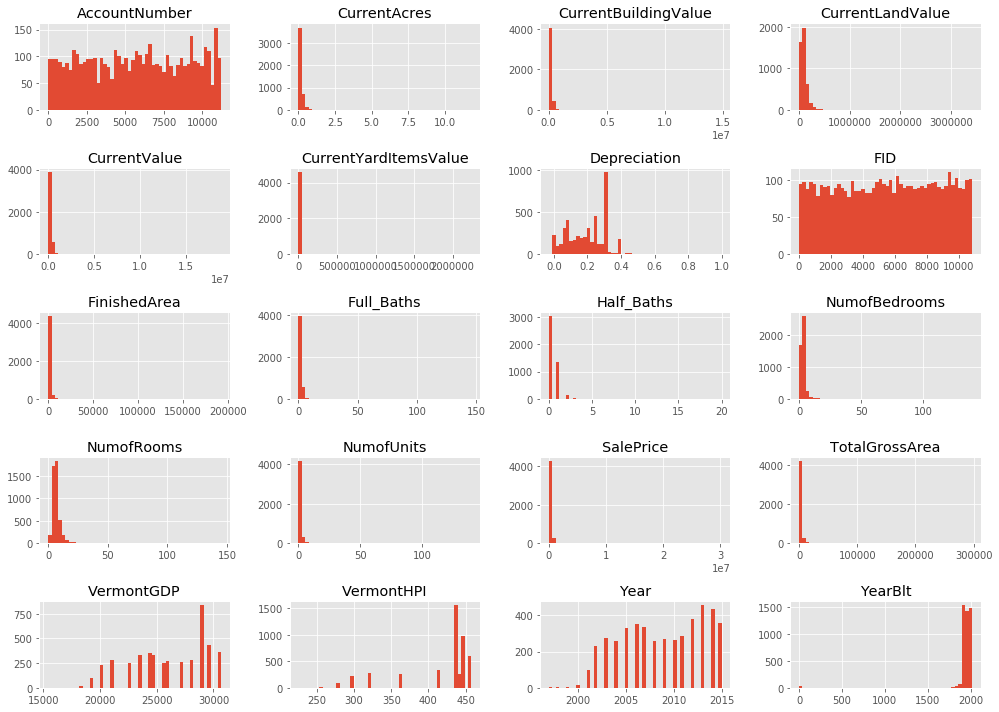

In [3]:
df.hist(figsize = (14, 10), bins = 50)
plt.tight_layout()
plt.show()

Let's take a quick look at the features that we have added, the Vermont GDP and HPI, over time. It appears that both are increasing steadily with some eradic behavior for the HPI from 2006 up until the US housing crisis.  We can see visually see the housing bubble. 

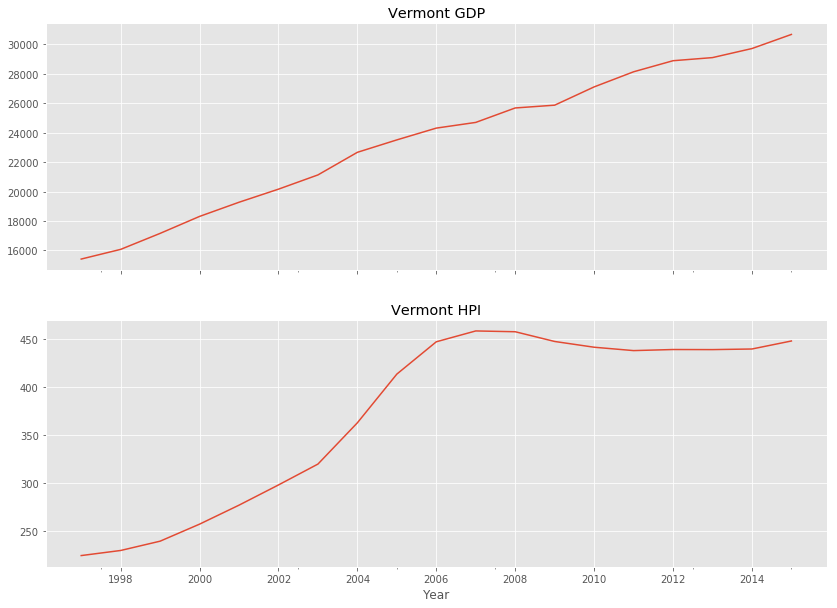

In [4]:
from matplotlib.ticker import MaxNLocator
gdp = df[['VermontGDP','Year']]
gdp  = gdp.groupby('Year').mean()
hpi  = df[['VermontHPI', 'Year']]
hpi  = hpi.groupby('Year').mean()
fig, ax = plt.subplots(2,1, sharex = True, figsize = (14, 10))
ax = ax.ravel()
gdp.plot(ax = ax[0], legend = False)
hpi.plot(ax = ax[1], legend = False)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[0].set_title('Vermont GDP')
ax[1].set_title('Vermont HPI')

plt.show()

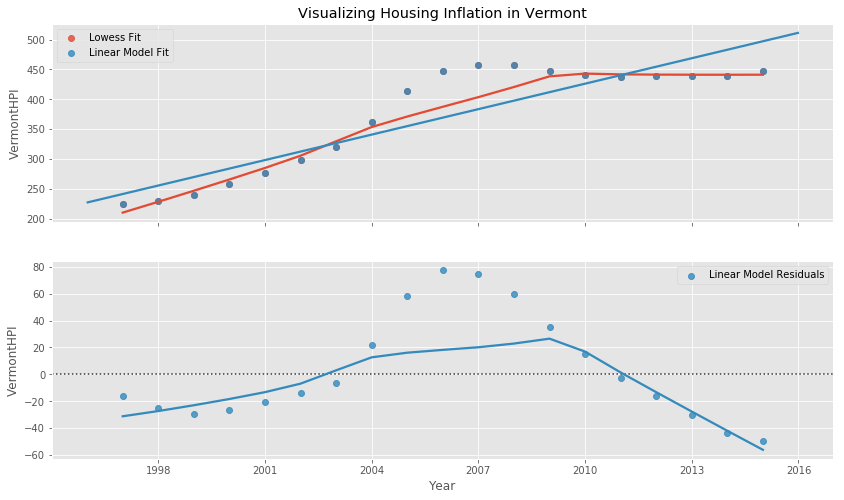

In [5]:
fig, ax = plt.subplots(2,1, figsize = (14,8), sharex=True)
ax = ax.ravel()
sns.regplot('Year', 'VermontHPI',hpi.reset_index(), ax = ax[0], lowess = True, label = 'Lowess Fit', color = 'C0')
sns.regplot('Year', 'VermontHPI',hpi.reset_index(), ax = ax[0], label = 'Linear Model Fit', ci = None, color = 'C1', robust = True)
ax[0].legend()
ax[0].set_xlabel("")
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
sns.residplot('Year', 'VermontHPI', hpi.reset_index(), ax = ax[1], color = 'C1', label = 'Linear Model Residuals', lowess = True, robust = True)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
ax[1].legend()
ax[0].set_title('Visualizing Housing Inflation in Vermont')
plt.show()

This EDA is a bit brief becasue I already have a notebook covering it.  The visualizations produced in this notebook are mostly new, and show other aspects of python data munging.

### Modeling

To perform the modeling of housing prices I first make use of the BasicTransformer class borrowed from this source:
https://colab.research.google.com/drive/1yHnTLJVWDzI7_WqjTlgRMBOTcwt8qIr1#scrollTo=VD_8-0VObs7B&forceEdit=true&offline=true&sandboxMode=true


update to include this:
https://github.com/DunderData/Machine-Learning-Tutorials/blob/master/LICENSE

In [47]:
#basetransformer modified from https://colab.research.google.com/drive/1yHnTLJVWDzI7_WqjTlgRMBOTcwt8qIr1#scrollTo=VD_8-0VObs7B&forceEdit=true&offline=true&sandboxMode=true
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler

class BasicTransformer(BaseEstimator):
    
    def __init__(self, cat_threshold=None, num_strategy='median', return_df=False):
        # store parameters as public attributes
        self.cat_threshold = cat_threshold
        
        if num_strategy not in ['mean', 'median']:
            raise ValueError('num_strategy must be either "mean" or "median"')
        self.num_strategy = num_strategy
        self.return_df = return_df
        
    def fit(self, X, y=None):
        # Assumes X is a DataFrame
        self._columns = X.columns.values
        
        # Split data into categorical and numeric
        self._dtypes = X.dtypes.values
        self._kinds = np.array([dt.kind for dt in X.dtypes])
        self._column_dtypes = {}
        is_cat = self._kinds == 'O'
        self._column_dtypes['cat'] = self._columns[is_cat]
        self._column_dtypes['num'] = self._columns[~is_cat]
        self._feature_names = self._column_dtypes['num']
        # it is essential to use one of Sklearn's scalers, otherwise you cannnot predict for single points
        # this is the only change that I have made from https://colab.research.google.com/drive/1yHnTLJVWDzI7_WqjTlgRMBOTcwt8qIr1#scrollTo=VD_8-0VObs7B&forceEdit=true&offline=true
        self._scaler = StandardScaler()
        # Create a dictionary mapping categorical column to unique values above threshold
        self._cat_cols = {}
        for col in self._column_dtypes['cat']:
            vc = X[col].value_counts()
            if self.cat_threshold is not None:
                vc = vc[vc > self.cat_threshold]
            vals = vc.index.values
            self._cat_cols[col] = vals
            self._feature_names = np.append(self._feature_names, col + '_' + vals)
            
        # get total number of new categorical columns    
        self._total_cat_cols = sum([len(v) for col, v in self._cat_cols.items()])
        
        # get mean or median
        self._num_fill = X[self._column_dtypes['num']].agg(self.num_strategy)
        self._scaler.fit(X[self._column_dtypes['num']])
        return self
    
        
    def transform(self, X):
        # check that we have a DataFrame with same column names as the one we fit
        if set(self._columns) != set(X.columns):
            raise ValueError('Passed DataFrame has different columns than fit DataFrame')
        elif len(self._columns) != len(X.columns):
            raise ValueError('Passed DataFrame has different number of columns than fit DataFrame')
            
        # fill missing values    
        X_num = X[self._column_dtypes['num']].fillna(self._num_fill)
        
        
        
        X_num = self._scaler.transform(X_num)
        
        # create separate array for new encoded categoricals
        X_cat = np.empty((len(X), self._total_cat_cols), dtype='int')
        i = 0
        for col in self._column_dtypes['cat']:
            vals = self._cat_cols[col]
            for val in vals:
                X_cat[:, i] = X[col] == val
                i += 1
                
                
        # concatenate transformed numeric and categorical arrays
        data = np.column_stack((X_num, X_cat))
        
        # return either a DataFrame or an array
        if self.return_df:
            return pd.DataFrame(data=data, columns=self._feature_names)
        else:
            return data
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    
    def get_feature_names(self):
        return self._feature_names

Before modeling I engineer one last feature, the distance from city hall. I used this source to pull approximate GPS coordinates for City Hall Park in Burlington.  This location is at the center of Downtown Burlington, one could think of it as the heart of town.

/anaconda3/envs/Main/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


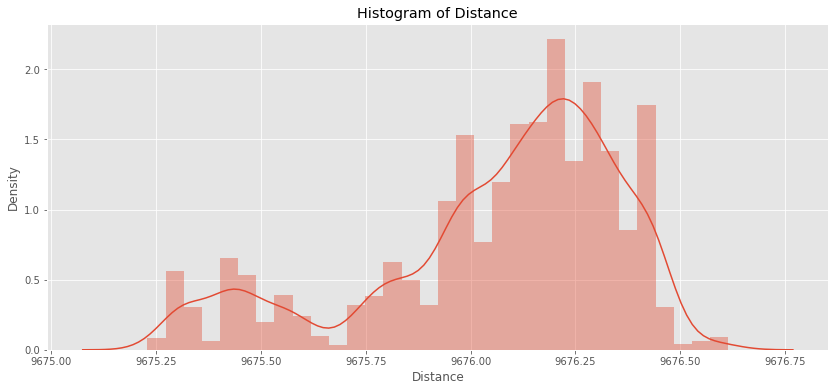

In [48]:
df['SaleDate'] = pd.to_datetime(df['SaleDate'])
modeldf = df.drop(['AccountNumber', 'ParcelID', 'SpanNumber', 'StreetNumber',
       'AlternateNumber', 'Unit', 'CuO1LastName',
       'CuO1FirstName', 'CuO2LastName', 'CuO2FirstName', 'CuO3LastName',
       'CuO3FirstName','LegalReference', 'GrantorLastName', 'FID', 'Baths'], axis = 1)
modeldf['Latitude'] = pd.to_numeric(modeldf['Latitude'])
modeldf['Longitude'] = pd.to_numeric(modeldf['Longitude'])
#modeldf['Sale_Year'] = modeldf['SaleDate'].apply(lambda row: row.year)
modeldf.drop('SaleDate', axis=1, inplace= True)
modeldf = modeldf[(modeldf['LandUse'] == "Single Family") | (modeldf['LandUse'] == "Residential Condo")]
modeldf = modeldf[modeldf['SalePrice']> 0]
modeldf.dropna(inplace = True)
#pulled cityhall gps coords from this https://www.maps.ie/coordinates.html
from geopy.distance import great_circle
distances = []
for i, j in zip(modeldf['Latitude'], modeldf['Longitude']):
    val = (i, j)
    Cityhall = (44.47647568031712, -73.21353835752235)
    dist = great_circle(val,Cityhall).miles
    distances.append(dist)
modeldf['Distances'] = distances
plt.figure(figsize = (14, 6))
sns.distplot(modeldf['Distances'])
plt.title('Histogram of Distance')
plt.ylabel('Density')
plt.xlabel('Distance')
plt.show()

In [117]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Ridge, BayesianRidge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
modeldf.dropna(inplace = True)
modeldf = pd.get_dummies(modeldf)
target_name = 'SalePrice'
y=modeldf[target_name]
Xframe = modeldf.drop(['SalePrice'], axis=1)
z
X = Xframe.copy()
# create train-test splits
X_train, X_test, y_train, y_test = train_test_split(X, y)
#y_train = y_train.values.ravel()

# create the instances of the regressors
lm = LinearRegression()
ridge = Ridge(alpha = 10)
blm = BayesianRidge()
rf = RandomForestRegressor()
gbm = GradientBoostingRegressor()
lasso = Lasso(alpha = 10)
bt = BasicTransformer(cat_threshold=5, return_df=True)

scores = []

regressors = [lm,lasso,ridge,rf,gbm, blm] 
names = ['lm','lasso' , 'ridge','rf', 'gbm', 'bayes ridge']
for i, j  in zip(regressors, names):
    basic_pipe = Pipeline([('bt', bt), (j, i)])
    basic_pipe.fit(X_train, y_train)
    score = cross_val_score(basic_pipe,X = X_train,y = y_train, cv = 10)
    scores.append([j,np.mean(score)])
    
    

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all con

/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Dat

/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/ana

/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardSca

/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardSca

/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [115]:
print(basic_pipe.score(X_test, y_test))


0.7730083196883014


/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


In [116]:
print('Crossvalidation Score:')
for i, j in scores:
    print(i +":", j)

Crossvalidation Score:
lm: -1.829360814604247e+24
lasso: 0.8605573779444912
ridge: 0.8606111404811025
rf: 0.8652397632154735
gbm: 0.8811872401445024
bayes ridge: 0.8588526833227368


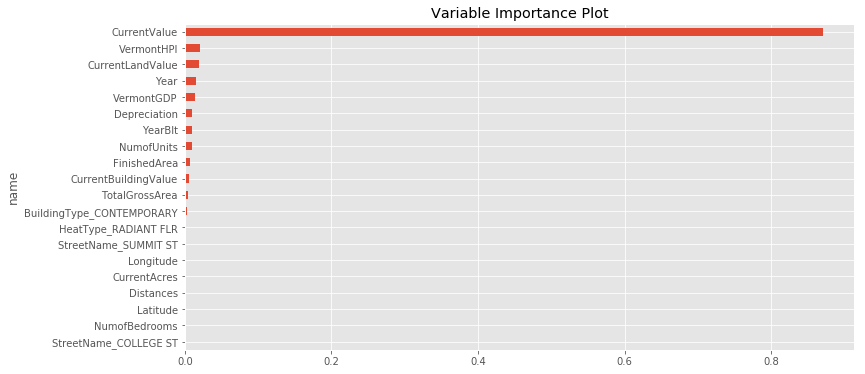

In [17]:
coef= []
name= []
for i,j in zip(gbm.feature_importances_, data_names):
    coef.append(i)
    name.append(j)
coefs = pd.DataFrame({'name': name, 'coef': coef}) 
top = coefs.sort_values('coef').tail(20)
fig, ax = plt.subplots(1,1,figsize = (12,6))
top.plot(kind = 'barh', x = 'name', y = 'coef', legend = False, color = 'C0', ax = ax)
plt.title('Variable Importance Plot')
plt.show()

In [18]:
print("percent of importances greater than 0:", len(list(filter(lambda x: x > 0, gbm.feature_importances_)))/len(gbm.feature_importances_))
print("total number of non zero importances:",len(list(filter(lambda x: x > 0, gbm.feature_importances_))))
print("total:", len(gbm.feature_importances_))      
      
      

percent of importances greater than 0: 0.16707021791767554
total number of non zero importances: 69
total: 413


/anaconda3/envs/Main/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/envs/Main/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


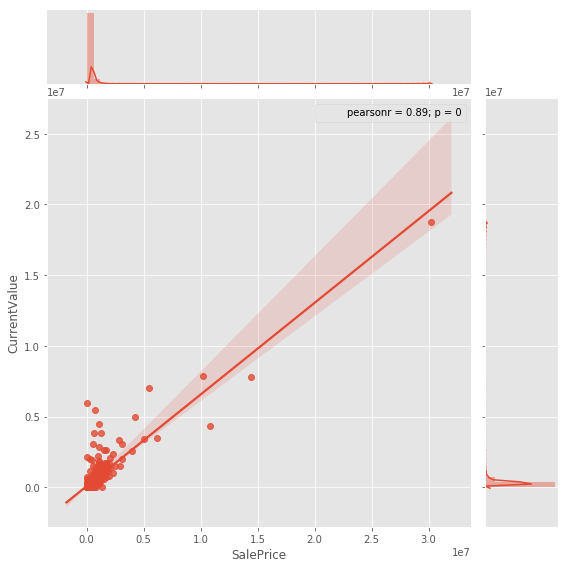

In [19]:
import scipy.stats as stats
j = sns.jointplot('SalePrice', 'CurrentValue', df, kind='reg', height=8)
j.annotate(stats.pearsonr)
plt.show()

/anaconda3/envs/Main/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


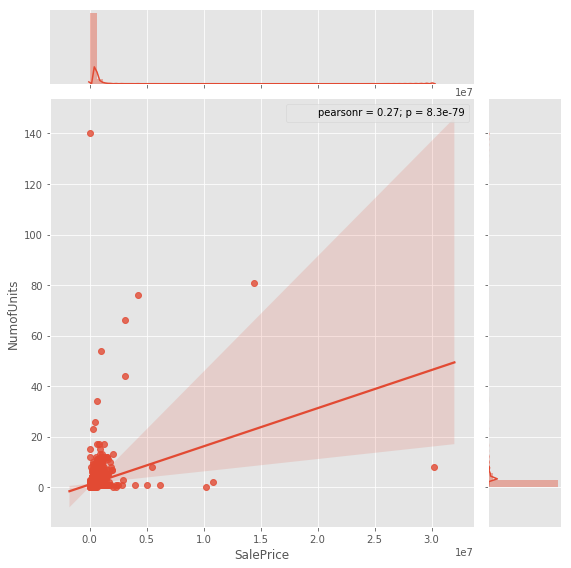

In [20]:
j = sns.jointplot('SalePrice', 'NumofUnits', df, kind='reg', height=8)
j.annotate(stats.pearsonr)
plt.show()

We can plot the coefficients to see the relative importance of variables.  Keep in mind that the data is scaled, this is why some of the coefficients are so large

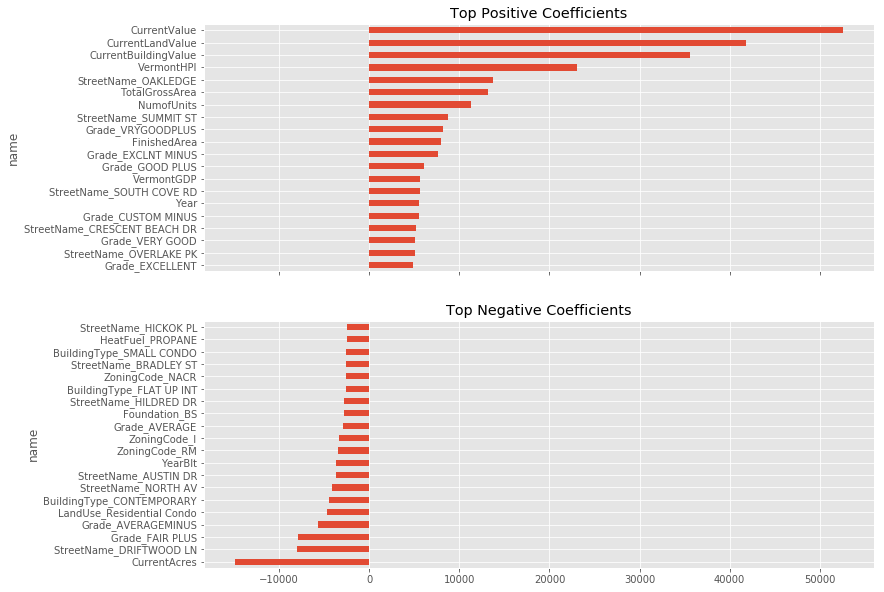

In [21]:
coef= []
name= []
for i,j in zip(blm.coef_, data_names):
    coef.append(i)
    name.append(j)
coefs = pd.DataFrame({'name': name, 'coef': coef}) 
top = coefs.sort_values('coef').tail(20)
fig, ax = plt.subplots(2,1,figsize = (12,10), sharex = True)
ax = ax.ravel()
top.plot(kind = 'barh', x = 'name', y = 'coef', legend = False, color = 'C0', ax = ax[0])
ax[0].set_title('Top Positive Coefficients')

coef= []
name= []
for i,j in zip(blm.coef_, data_names):
    coef.append(i)
    name.append(j)
coefs = pd.DataFrame({'name': name, 'coef': coef}) 
coefs.sort_values('coef').head(20).plot(kind='barh', x= 'name', y = 'coef', ax = ax[1], color = 'C0', legend = False)
ax[1].set_title('Top Negative Coefficients')





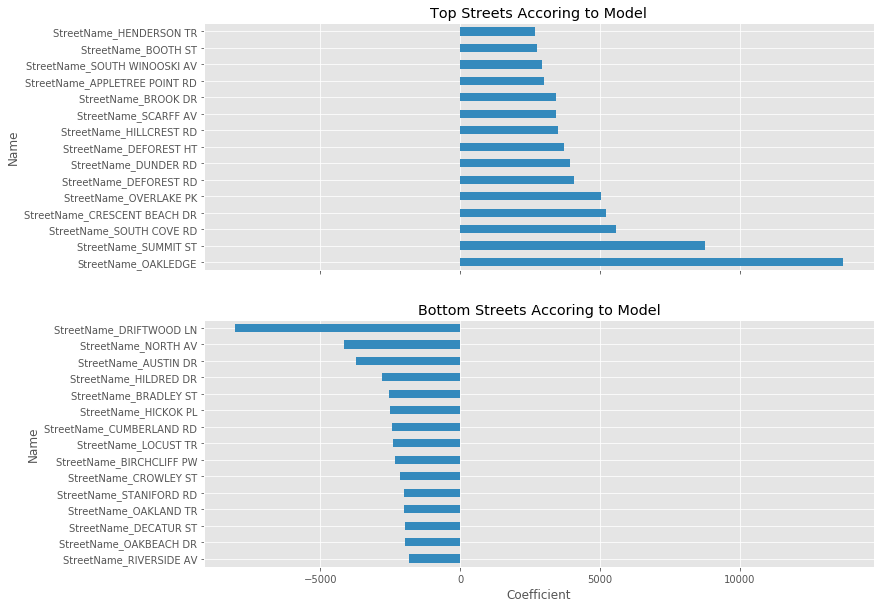

In [101]:
fig, ax = plt.subplots(2, 1, figsize = (12,10), sharex = True)


streets = coefs[coefs['name'].str.contains("StreetName")].sort_values('coef', ascending = False).head(15)
streets.plot(x = 'name', y='coef',kind='barh', color = 'C1', ax = ax[0], legend = False)
ax[0].set_title('Top Streets Accoring to Model')
ax[0].set_xlabel('Coefficient')
ax[0].set_ylabel('Name')



streets = coefs[coefs['name'].str.contains("StreetName")].sort_values('coef', ascending = False).tail(15)
streets.plot(x = 'name', y='coef',kind='barh', color = 'C1', ax = ax[1], legend = False)
ax[1].set_title('Bottom Streets Accoring to Model')
ax[1].set_xlabel('Coefficient')
ax[1].set_ylabel('Name')
plt.show()


In [107]:
X_train[X_train['StreetName_DRIFTWOOD LN'] == 1]

,CurrentAcres,TotalGrossArea,FinishedArea,CurrentValue,CurrentLandValue,CurrentYardItemsValue,CurrentBuildingValue,YearBlt,NumofRooms,NumofBedrooms,...,ZoningCode_RL-W,ZoningCode_RLW,ZoningCode_RM,ZoningCode_RMW,Foundation_BS,Foundation_C,Foundation_CB,Foundation_CS,Foundation_P,Foundation_S
84,1.01451,12208,5120.3999,1819500.0,898300,0,921200.0,2009,10,4,...,0,1,0,0,0,1,0,0,0,0


In [109]:
y_train.iloc[84]

202000

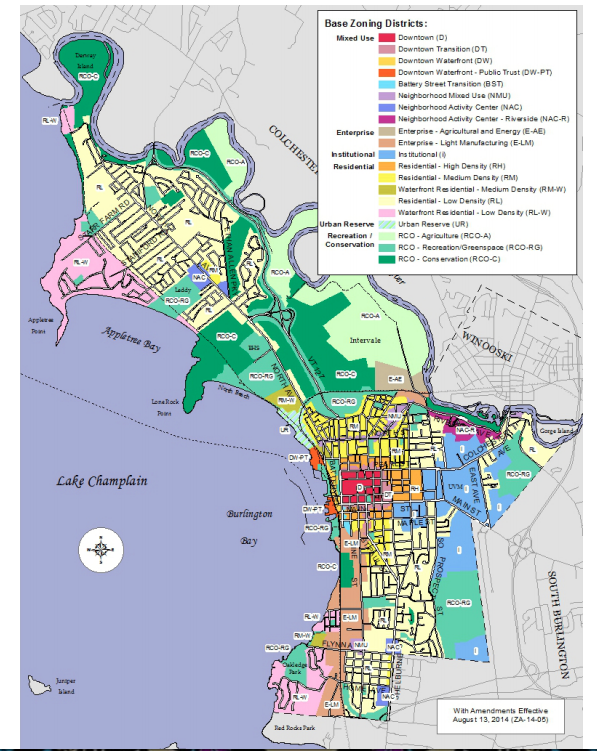


In [61]:
print(X_train.shape)
print(X_test.shape)

(2557, 413)
(853, 413)


In [41]:
#used to show how the data is strandardized and explain the size of the coefficients
BasicTransformer(return_df=True).fit_transform(X_train).head(2)

/anaconda3/envs/Main/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


,CurrentAcres,TotalGrossArea,FinishedArea,CurrentValue,CurrentLandValue,CurrentYardItemsValue,CurrentBuildingValue,YearBlt,NumofRooms,NumofBedrooms,...,ZoningCode_RL-W,ZoningCode_RLW,ZoningCode_RM,ZoningCode_RMW,Foundation_BS,Foundation_C,Foundation_CB,Foundation_CS,Foundation_P,Foundation_S
0,1.446898,-0.154442,0.181080,0.017480,0.103620,-0.308632,-0.068553,0.406953,0.074056,0.188526,...,-0.01978,-0.409365,-0.356270,-0.062659,-0.46214,-0.63514,1.405958,-0.039583,0.0,-0.498533
1,-0.733482,-0.755232,-0.516991,-0.760001,-0.752279,-0.308632,-0.372035,0.616856,-0.501509,0.188526,...,-0.01978,-0.409365,2.806862,-0.062659,-0.46214,-0.63514,1.405958,-0.039583,0.0,-0.498533


There are a few reasons I chose the bayesian ridge over other models.

 * It is one of the most accurate in cross valadation (some runs it has the highest score, others it is beat by the random forest or GBM. This is a concequence of the randomness of the algorithms when fit. 

* The bayesian ridge returns interpretable coefficients that we can use to understand variable importance and sign. The bayesian ridge does a good job of dealing with multi-collinearity but some coefficients may still be unreliable for inference due to the shrinkage and multi-colinearity - refer to this dicussion for more: https://stats.stackexchange.com/questions/291622/using-regularization-when-doing-statistical-inference 


* The bayesian ridge returns the posterior predictive mean and std for each individual observation it predicts.  This allows us to make a simple calculation to obtain a predictive credible interval for the price of an invididual home.

In [42]:
# for some reason I need to make a copy of X_test because of slicing errors
X_test = X_test.copy()
# Make sure to pass the appropriate argument to return the posterior sd, this provides big insights!
pred = basic_pipe.predict(X_test, return_std=True)


/anaconda3/envs/Main/lib/python3.6/site-packages/ipykernel_launcher.py:62: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.


Point predictions:

In [43]:
for j, i in enumerate(pred[0]):
    print(i)
    if j == 10:
        break

543125.4612584496
231024.7911369598
1239705.9938084485
208519.78273256507
297338.5045462624
500406.1600052203
283618.1442617822
226177.75557319116
162143.1799636221
282116.6074222441
301874.2404769532


Posterior prediction sds

In [44]:
for j, i in enumerate(pred[1]):
    print(i)
    if j == 10:
        break

59798.204345884806
59742.798795696974
84999.32581397843
64238.45992349944
57796.28838544426
70322.62011231249
57846.78091092344
60580.02588109375
58037.43269675591
61138.937652772394
60620.752845379015


In [31]:
for i, j, k in zip(range(len(pred[0])), pred[0], pred[1]):
    print('''the property is predicticted to sell for {}, The posterior predictive distribution tells us are 95% certain the sale price will fall 
          between {} and {}'''.format(j, j - (1.96 * k), j + (1.96 * k)))
    if i == 3:
        break
    

the property is predicticted to sell for 543125.4612584496, The posterior predictive distribution tells us are 95% certain the sale price will fall 
          between 425920.9807405154 and 660329.9417763838
the property is predicticted to sell for 231024.7911369598, The posterior predictive distribution tells us are 95% certain the sale price will fall 
          between 113928.90549739373 and 348120.67677652586
the property is predicticted to sell for 1239705.9938084485, The posterior predictive distribution tells us are 95% certain the sale price will fall 
          between 1073107.315213051 and 1406304.6724038462
the property is predicticted to sell for 208519.78273256507, The posterior predictive distribution tells us are 95% certain the sale price will fall 
          between 82612.40128250618 and 334427.16418262396
